### CITS4404 Practical Project

# Camo Worms!

<div style="margin-left: 0px">
    &nbsp;
    <img src="velvet-worms.jpg" width=600>
    <br>
    <br>
</div>

Australian _velvet worms_ come in many colours, possibly as a camouflage function ([Current Biology](https://www.cell.com/current-biology/comments/S0960-9822(11)00208-9)).

In [1]:
# Imports

import numpy as np
import imageio.v3 as iio

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib.bezier as mbezier
from sklearn.metrics.pairwise import euclidean_distances

rng = np.random.default_rng()
Path = mpath.Path
mpl.rcParams['figure.dpi']= 72 #size of images


In [2]:
# Global variables

IMAGE_DIR = 'images'
IMAGE_NAME='original'
MASK = [320, 560, 160, 880] # ymin ymax xmin xmax

Image name (shape) (intensity max, min, mean, std)

original (240, 720) (210, 0, 49.3, 34.8)


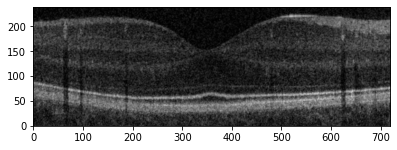

In [3]:
# Read, crop and display image and stats

def crop (image, mask):
    h, w = np.shape(image)
    return image[max(mask[0],0):min(mask[1],h), max(mask[2],0):min(mask[3],w)]

def prep_image (imdir, imname, mask):
    print("Image name (shape) (intensity max, min, mean, std)\n")
    image = np.flipud(crop(iio.imread(imdir+'/'+imname+".png"), mask))
    print("{} {} ({}, {}, {}, {})".format(imname, np.shape(image), np.max(image), np.min(image), round(np.mean(image),1), round(np.std(image),1)))
    plt.imshow(image, vmin=0, vmax=255, cmap='gray', origin='lower') # use vmin and vmax to stop imshow from scaling
    plt.show()
    return image

image = prep_image(IMAGE_DIR, IMAGE_NAME, MASK)

In [4]:
import time

start_time = time.time()
function_times = {}

def measure_time(f):
    def timed(*args, **kw):
        ts = time.time()
        result = f(*args, **kw)
        te = time.time()
        function_time = te - ts
        
        if f.__name__ not in function_times:
            function_times[f.__name__] = [0, 0]  # [total_time, call_count]
        function_times[f.__name__][0] += function_time
        function_times[f.__name__][1] += 1
        
        return result
    
    return timed

def print_function_times():
    end_time = time.time()
    total_program_time = end_time - start_time
    
    print()
    print("### PROFILING ###")
    print("Total program time: {:.2f} sec".format(total_program_time))
    print("Function times:")
    for function_name, (total_time, call_count) in function_times.items():
        percentage = (total_time / total_program_time) * 100
        average_time = total_time / call_count
        print("- {}: {:.2f} sec ({:.2f}%), {} calls".format(
            function_name, total_time, percentage, call_count, average_time))
    print()

In [5]:
class Camo_Worm:
    def __init__(self, x, y, r, theta, deviation_r, deviation_gamma, width, colour):
        self.x = x
        self.y = y
        self.r = r
        self.theta = theta
        self.dr = deviation_r
        self.dgamma = deviation_gamma
        self.width = width
        self.colour = colour
        p0 = [self.x - self.r * np.cos(self.theta), self.y - self.r * np.sin(self.theta)]
        p2 = [self.x + self.r * np.cos(self.theta), self.y + self.r * np.sin(self.theta)]
        p1 = [self.x + self.dr * np.cos(self.theta+self.dgamma), self.y + self.dr * np.sin(self.theta+self.dgamma)]
        self.bezier = mbezier.BezierSegment(np.array([p0, p1,p2]))

    def control_points (self):
        return self.bezier.control_points

    def path (self):
        return mpath.Path(self.control_points(), [Path.MOVETO, Path.CURVE3, Path.CURVE3])

    def patch (self):
        return mpatches.PathPatch(self.path(), fc='None', ec=str(self.colour), lw=self.width, capstyle='round')

    def intermediate_points (self, intervals=None):
        if intervals is None:
            intervals = max(3, int(np.ceil(self.r/8)))
        return self.bezier.point_at_t(np.linspace(0,1,intervals))

    def approx_length (self):
        intermediates = intermediate_points(self)
        eds = euclidean_distances(intermediates,intermediates)
        return np.sum(np.diag(eds,1))
    
    @measure_time
    def colour_at_t(self, t, image):
        intermediates = np.int64(np.round(np.array(self.bezier.point_at_t(t)).reshape(-1,2)))
        height, width = image.shape[:2]
        intermediates[:, 0] = np.clip(intermediates[:, 0], 0, width - 1)
        intermediates[:, 1] = np.clip(intermediates[:, 1], 0, height - 1)
        colours = [image[point[1],point[0]] for point in intermediates] #? had to swap point[1] and point[0] cause y and x were in the other order
        return(np.array(colours)/255)
    
    @measure_time
    def img_color_across_t(self, t, image):
        # average image colour across all points in t 
        intermediates = np.int64(np.round(np.array(self.bezier.point_at_t(t)).reshape(-1,2)))
        try:
            return np.array(image[intermediates[:, 1], intermediates[:, 0]]) / 255.0
        except:
            return np.array([0 for _ in range(len(t))])


In [6]:
class Drawing:
    def __init__ (self, image):
        self.fig, self.ax = plt.subplots()
        self.image = image
        self.im = self.ax.imshow(self.image, cmap='gray', origin='lower')

    def add_patches(self, patches):
        try:
            for patch in patches:
                self.ax.add_patch(patch)
        except TypeError:
            self.ax.add_patch(patches)

    def add_dots(self, points, radius=4, **kwargs):
        try:
            for point in points:
                self.ax.add_patch(mpatches.Circle((point[0],point[1]), radius, **kwargs))
        except TypeError:
            self.ax.add_patch(mpatches.Circle((points[0],points[1]), radius, **kwargs))

    def add_worms(self, worms, alpha=1.0, colour=None):
        colourmap = mpl.colormaps["rainbow"]
        try:
            for worm in worms:
                patch = worm.patch()
                patch.set_alpha(alpha)
                if colour != None:
                    patch.set_edgecolor(colourmap(colour))
                self.ax.add_patch(patch)
        except TypeError:
            patch = worms.patch()
            patch.set_alpha(alpha)
            if colour != None:
                patch.set_edgecolor(colourmap(colour))
            self.ax.add_patch(patch)

    def show(self, save=None):
        if save is not None:
            plt.savefig(save)
        plt.show()


In [7]:
# Example of a random worm. You may do this differently.

    # centre points, angles and colour chosen from uniform distributions
    # lengths chosen from normal distributions with two std parameters passed
    # width chosen from gamma distribution with shape parameter 3 and scale passed

def random_worm (imshape, init_params):
    (radius_std, deviation_std, width_theta) = init_params
    (ylim, xlim) = imshape
    midx = xlim * rng.random()
    midy = ylim * rng.random()
    r = radius_std * np.abs(rng.standard_normal())
    theta = rng.random() * np.pi
    dr = deviation_std * np.abs(rng.standard_normal())
    dgamma = rng.random() * np.pi
    colour = rng.random()
    width = width_theta * rng.standard_gamma(3)
    return Camo_Worm(midx, midy, r, theta, dr, dgamma, width, colour)


In [8]:
# Initialise a random clew
def initialise_clew (size, imshape, init_params):
    clew = []
    for i in range(size):
        clew.append(random_worm(imshape, init_params))
    return clew

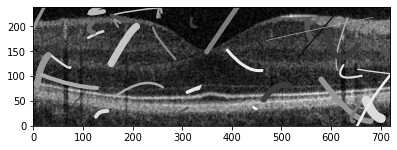

In [9]:
# Initialise clew of 40 and draw
clew = initialise_clew(40, image.shape, (40, 30, 1))
drawing = Drawing(image)
drawing.add_worms(clew)
drawing.show()

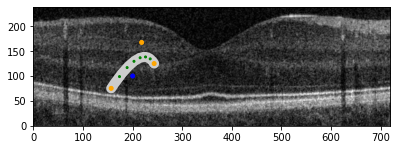

In [10]:
# Draw a single worm along with control points and some sample points

worm = Camo_Worm(200, 100, 50, np.pi/6, 70, np.pi/4, 10, 0.8)
drawing = Drawing(image)
drawing.add_worms(worm)
drawing.add_dots(worm.intermediate_points(8), radius=2, color='green')
drawing.add_dots(worm.control_points(),color='orange')
drawing.add_dots((200,100), color='blue')

drawing.show(save='bezier.png')

In [11]:
# ctrlf
# def __init__(self, x, y, r, theta, deviation_r, deviation_gamma, width, colour):

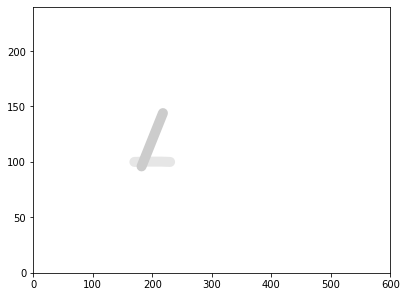

Overlap Area: 0.0
Do the paths cross? Yes


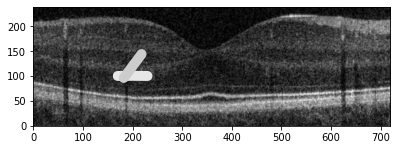

In [15]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from shapely.geometry import Polygon, LineString
from matplotlib.path import Path

def path_to_shapely_line(path):
    """Converts a Matplotlib path to a Shapely LineString."""
    return LineString(path.vertices)

def paths_cross(path1, path2):
    """Determines if two Matplotlib paths cross."""
    line1 = path_to_shapely_line(path1)
    line2 = path_to_shapely_line(path2)
    
    # Check if the lines intersect and that the intersection is not just touching
    if line1.intersects(line2) and not line1.touches(line2):
        return True
    return False

def patch_to_polygon(patch):
    vertices = patch.get_path().vertices
    polygon = Polygon(vertices)
    return polygon

# pause on this for now
def calculate_overlap(patch1, patch2):
    """Calculates the area of overlap between two Matplotlib patches."""
    # Convert patches to polygons
    poly1 = patch_to_polygon(patch1)
    poly2 = patch_to_polygon(patch2)
    
    # Calculate intersection
    intersection = poly1.intersection(poly2)
    
    # Return the area of the intersection
    return intersection.area

# Create example patches
fig, ax = plt.subplots()
worm1 = Camo_Worm(200, 100, 30, 0, 1, np.pi/4, 10, 0.9)
worm2 = Camo_Worm(200, 120, 30, 180, 0, np.pi/4, 10, 0.8)
patch1 = worm1.patch()
patch2 = worm2.patch()

ax.add_patch(patch1)
ax.add_patch(patch2)
plt.xlim(0, 600)
plt.ylim(0, 240)
plt.show()

drawing = Drawing(image)
drawing.add_worms(worm1)
drawing.add_worms(worm2)

# Calculate and print the overlap
overlap_area = calculate_overlap(patch1, patch2)
print(f"Overlap Area: {overlap_area}")

# Convert patch paths to matplotlib paths
path1 = patch1.get_path()
path2 = patch2.get_path()

# Check and print if paths cross
cross = paths_cross(path1, path2)
print(f"Do the paths cross? {'Yes' if cross else 'No'}")


In [22]:
class Fitness:
    def __init__(self, image, swarms):
        self.image = image
        self.swarms = swarms
        self.times = {}
        
    @measure_time
    def get(self, worm):
        img_height, img_width = self.image.shape[:2]
        # colour factor
        @measure_time
        def colour():
            DIVISIONS = 10
            t = np.linspace(0,1,DIVISIONS)
            # subtract from 1 since higher fitness is better
            return (1 - np.mean(np.abs(worm.colour - worm.img_color_across_t(t, self.image))),3.5)

        @measure_time
        # width factor
        def width():
            # example weakly encouraging width to be 8
            return (1 / max(abs(worm.width - 5),1),5) 

        @measure_time
        # length factor
        def length():
            # provides benefit up to a value of img_width/8 then no more benefit
            return (min(worm.r/(img_width/8),1),1)

        @measure_time
        # discourage from going out of bounds
        def outside():
            min_x, min_y = np.min(worm.control_points(), axis=0)
            max_x, max_y = np.max(worm.control_points(), axis=0)
            if min_x < 0 or max_x >= img_width or min_y < 0 or max_y >= img_height:
                return (-1, 10)  # high cost for going outside
            else:
                return (0, 0) # doesn't affect worm if it's inside boundaries
        
        @measure_time
        # distance between swarms
        def g_distance():
            # take the first worm instead of the actual average of all worms in that swarm for speed
            avgs = [s.population[0] for s in swarms if worm not in s.population] 
            distances = [(abs(worm.x - a.x)**2 + abs(worm.y - a.y)**2)**0.5 for a in avgs]
            distances.sort()
            distance = distances[0] # take closest (smallest) distance 
            distance = min(distance, min(img_width, img_height)*2 / np.ceil(len(swarms)**0.5))
            # normalise distance by dividing by the maximum minimum distance between points in a rectangle
            distance /= min(img_width, img_height) / np.ceil(len(swarms)**0.5)
            return (distance, 1)
        @measure_time
        # detect if the worm is crossing another, penalise heavily
        def g_cross_factor():
            target_path = worm.path()  # Get the path of the target worm
            # take the first worm instead of the actual average of all worms in that swarm for speed
            avgs = [s.population[0] for s in swarms[::len(swarms)//10] if worm not in s.population] 
            # Iterate over all swarms
            for a in avgs:
                if worm != a:  # Ensure we do not compare the worm to itself
                    a_path = a.path()  # Get the path of the other worm
                    if paths_cross(target_path, a_path):
                        # if the worm crosses another, it is heavily penalised
                        return (-1,10)
            return (0, 0)
        
        # each factor is a tuple of (fitness, multiplier)
        factors = [outside(), g_cross_factor(), width(), length()]
        return sum([x[0] * x[1] for x in factors])

In [23]:
import random, copy
"""
Each Swarm represents a single worm 
"""
class Swarm:
    def __init__ (self, image, population):
        self.image = image
        self.population = population
        self.fitness = None # must be updated after Fitness class is created
        
        # CONSTANTS #
        
        # number of individuals in the selection tournament
        # a higher tnm_k means it will select more of the best, and less of the worst
        # may converge faster without as much exploration
        self.tnm_k = 3
        
        # rate of mutation which should be between 0 and 1
        # a high rate may prevent convergence, a low rate will need more iterations to converge
        self.m_rate = 0.01 
    @measure_time
    def update(self):
        assert(self.fitness != None)
        fitnesses = [fitness.get(x) for x in self.population]
        new_population = []
        size = len(self.population)
        for i in range(size):
            # tournament selection
            selected_ix = random.randint(0,size-1)
            for ix in [random.randint(0,size-1) for x in range(self.tnm_k-1)]:
                if fitnesses[ix] > fitnesses[selected_ix]:
                    selected_ix = ix
            parent = self.population[selected_ix]
            # mutating
            height, width = image.shape[:2]
            c_x = min(max(parent.x + random.uniform(-self.m_rate*width/2,self.m_rate*width/2),0),width)
            c_y = min(max(parent.y + random.uniform(-self.m_rate*height/2,self.m_rate*height/2),0),height)
            max_r = max(width,height)/2
            c_r = min(max(parent.r + random.uniform(-self.m_rate*max_r/2,self.m_rate*max_r/2),0),max_r)
            c_colour = min(max(parent.colour + random.uniform(-self.m_rate/2,self.m_rate/2),0),1)
            c_theta = (parent.theta + random.uniform(-self.m_rate*np.pi,self.m_rate*np.pi)) % (np.pi*2)
            c_dr = min(max(parent.dr + random.uniform(-self.m_rate*c_r,self.m_rate*c_r),-c_r),c_r)
            c_dgamma = min(max(parent.dgamma + random.uniform(-self.m_rate*np.pi,self.m_rate*np.pi),-np.pi),np.pi)
            c_width = min(max(parent.width + random.uniform(-self.m_rate*c_r,self.m_rate*c_r),1),2*c_r)
            # child
            child = Camo_Worm(c_x, c_y, c_r, c_theta, c_dr, c_dgamma, c_width, c_colour)
            new_population.append(child)
        self.population = new_population
    @measure_time
    def avg_worm(self):
        avg = copy.deepcopy(self.population[0])
        for field in ['x', 'y', 'r', 'theta', 'dr', 'dgamma', 'width']:
            setattr(avg, field, np.mean([getattr(w, field) for w in self.population]))
        return avg
    

Iteration: 20
Time Remaining: 91 seconds
Fitness: [4.1, 1.95, 3.06, 4.09, 3.64, 2.22, 3.46, 1.89, 4.0, 3.32, 3.67, 2.67, 3.82, 3.55, 1.9, 3.13, 3.09, 1.76, 3.96, 3.16, 3.48, 3.57, 3.39, 2.07, 3.87, 3.17, 2.66, 3.45, 3.54, 4.13]
Mutation Rate: 0.0752
Tournament Size: 2

### PROFILING ###
Total program time: 10.17 sec
Function times:
- outside: 0.52 sec (5.14%), 25200 calls
- g_cross_factor: 8.34 sec (81.98%), 25200 calls
- width: 0.06 sec (0.55%), 25200 calls
- length: 0.02 sec (0.19%), 25200 calls
- get: 9.20 sec (90.45%), 25200 calls
- update: 9.70 sec (95.37%), 600 calls



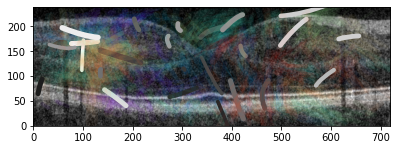


Iteration: 40
Time Remaining: 94 seconds
Fitness: [4.44, 3.67, 4.84, 4.01, 2.67, 4.09, 4.29, 4.17, 0.196, 4.56, 3.82, 3.58, 4.89, 3.72, 4.13, 4.21, 4.29, 2.84, 3.59, 3.68, 3.93, 3.05, 3.91, 4.26, 4.37, 3.67, 4.3, 4.04, 3.3, 4.02]
Mutation Rate: 0.0557
Tournament Size: 2

### PROFILING ###
Total program time: 23.52 sec
Function times:
- outside: 1.07 sec (4.55%), 50400 calls
- g_cross_factor: 17.68 sec (75.15%), 50400 calls
- width: 0.11 sec (0.45%), 50400 calls
- length: 0.05 sec (0.19%), 50400 calls
- get: 19.42 sec (82.57%), 50400 calls
- update: 20.46 sec (86.99%), 1200 calls
- avg_worm: 0.01 sec (0.03%), 30 calls



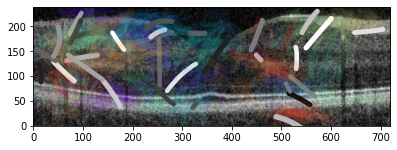


Iteration: 60
Time Remaining: 85 seconds
Fitness: [2.85, 3.79, 4.38, 4.42, 4.07, 4.74, 4.15, 0.475, 1.64, 4.64, 2.97, 1.74, 2.81, 4.24, 4.15, 4.6, 1.63, 3.83, 2.59, 1.59, 4.27, 2.95, 4.47, 4.16, 4.71, 4.68, 4.05, 2.43, 3.93, 3.39]
Mutation Rate: 0.0413
Tournament Size: 3

### PROFILING ###
Total program time: 36.48 sec
Function times:
- outside: 1.68 sec (4.60%), 75600 calls
- g_cross_factor: 26.88 sec (73.70%), 75600 calls
- width: 0.16 sec (0.43%), 75600 calls
- length: 0.07 sec (0.19%), 75600 calls
- get: 29.59 sec (81.12%), 75600 calls
- update: 31.18 sec (85.47%), 1800 calls
- avg_worm: 0.01 sec (0.03%), 60 calls



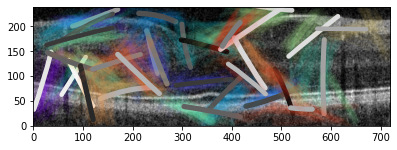


Iteration: 80
Time Remaining: 75 seconds
Fitness: [4.07, 2.61, 3.6, 4.22, 3.5, -5.44, 4.08, 4.18, 1.05, 1.17, 2.47, 3.21, 3.43, 3.77, 4.24, 3.45, -0.56, -1.96, 0.383, -1.74, 2.33, 3.59, 2.98, 3.01, 2.17, 2.83, 2.2, 3.03, 3.02, 0.925]
Mutation Rate: 0.0306
Tournament Size: 5

### PROFILING ###
Total program time: 50.07 sec
Function times:
- outside: 2.33 sec (4.65%), 100800 calls
- g_cross_factor: 36.77 sec (73.43%), 100800 calls
- width: 0.21 sec (0.42%), 100800 calls
- length: 0.10 sec (0.21%), 100800 calls
- get: 40.49 sec (80.86%), 100800 calls
- update: 42.66 sec (85.20%), 2400 calls
- avg_worm: 0.02 sec (0.05%), 90 calls



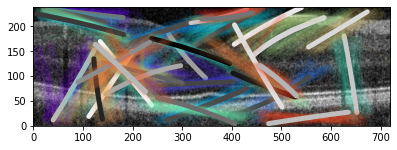


Iteration: 100
Time Remaining: 64 seconds
Fitness: [4.45, 1.62, 0.603, 4.89, 4.8, 4.77, 3.09, 4.61, 2.01, 4.89, 4.25, 4.12, 5.06, 3.02, 4.52, 4.4, 4.3, -0.157, 4.33, 3.1, 4.53, 2.4, 2.64, 2.48, 5.04, 4.81, 5.08, 5.05, 3.98, 2.58]
Mutation Rate: 0.0227
Tournament Size: 8

### PROFILING ###
Total program time: 64.56 sec
Function times:
- outside: 3.03 sec (4.70%), 126000 calls
- g_cross_factor: 47.35 sec (73.33%), 126000 calls
- width: 0.29 sec (0.46%), 126000 calls
- length: 0.14 sec (0.21%), 126000 calls
- get: 52.20 sec (80.84%), 126000 calls
- update: 54.74 sec (84.79%), 3000 calls
- avg_worm: 0.03 sec (0.05%), 120 calls



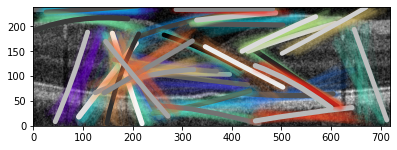


Iteration: 120
Time Remaining: 52 seconds
Fitness: [5.55, 3.48, 4.84, 5.48, 4.64, 4.87, 5.32, 4.5, 3.59, 4.56, 5.23, -0.854, 4.8, 4.99, 4.63, 5.09, 5.64, -0.254, 3.0, 0.433, 5.26, 5.19, 5.0, 4.87, 5.19, 5.54, 5.21, 3.42, 3.74, 1.11]
Mutation Rate: 0.0168
Tournament Size: 11

### PROFILING ###
Total program time: 78.38 sec
Function times:
- outside: 3.64 sec (4.65%), 151200 calls
- g_cross_factor: 57.00 sec (72.72%), 151200 calls
- width: 0.35 sec (0.45%), 151200 calls
- length: 0.16 sec (0.21%), 151200 calls
- get: 62.83 sec (80.16%), 151200 calls
- update: 65.98 sec (84.18%), 3600 calls
- avg_worm: 0.04 sec (0.05%), 150 calls



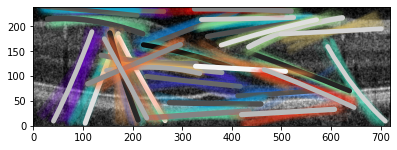


Iteration: 140
Time Remaining: 40 seconds
Fitness: [5.49, 4.91, 5.4, 5.69, 5.77, 5.47, 5.49, 5.01, 3.98, 5.26, 5.54, 3.95, 5.67, 5.39, 5.13, 5.68, 5.25, 2.18, 4.54, -0.762, 5.54, 5.73, 5.69, 5.75, 5.71, 5.27, 4.95, 5.61, 5.54, 3.15]
Mutation Rate: 0.0124
Tournament Size: 15

### PROFILING ###
Total program time: 93.51 sec
Function times:
- outside: 4.34 sec (4.64%), 176400 calls
- g_cross_factor: 67.65 sec (72.35%), 176400 calls
- width: 0.40 sec (0.43%), 176400 calls
- length: 0.20 sec (0.22%), 176400 calls
- get: 74.60 sec (79.78%), 176400 calls
- update: 78.51 sec (83.96%), 4200 calls
- avg_worm: 0.05 sec (0.05%), 180 calls



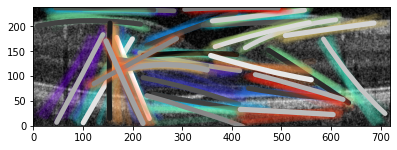


Iteration: 160
Time Remaining: 26 seconds
Fitness: [5.88, 2.63, 4.99, 5.83, 5.86, 5.12, 5.84, 5.76, 4.46, 5.93, 4.87, 5.83, 5.58, 4.74, 5.78, 5.87, -4.24, 5.01, 5.69, 5.87, 5.32, 4.86, 5.8, 5.46, 5.67, 5.08, 4.87, 5.89, 5.44, 4.28]
Mutation Rate: 0.00921
Tournament Size: 20

### PROFILING ###
Total program time: 107.73 sec
Function times:
- outside: 4.98 sec (4.62%), 201600 calls
- g_cross_factor: 77.80 sec (72.22%), 201600 calls
- width: 0.46 sec (0.42%), 201600 calls
- length: 0.23 sec (0.21%), 201600 calls
- get: 85.77 sec (79.62%), 201600 calls
- update: 90.52 sec (84.03%), 4800 calls
- avg_worm: 0.05 sec (0.05%), 210 calls



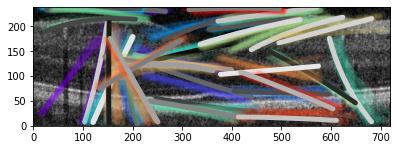


Iteration: 180
Time Remaining: 13 seconds
Fitness: [5.89, 5.38, 4.86, 5.9, 5.65, 5.97, 5.91, 4.76, 3.16, 5.95, 5.91, 5.91, 5.93, 5.81, 5.82, 5.94, -4.08, 4.97, 5.82, 4.68, 5.89, 5.96, 5.86, 5.9, 5.91, 5.87, 5.62, 5.83, 5.94, 5.68]
Mutation Rate: 0.00682
Tournament Size: 25

### PROFILING ###
Total program time: 120.42 sec
Function times:
- outside: 5.49 sec (4.56%), 226800 calls
- g_cross_factor: 86.59 sec (71.91%), 226800 calls
- width: 0.51 sec (0.42%), 226800 calls
- length: 0.27 sec (0.22%), 226800 calls
- get: 95.41 sec (79.23%), 226800 calls
- update: 100.97 sec (83.84%), 5400 calls
- avg_worm: 0.06 sec (0.05%), 240 calls



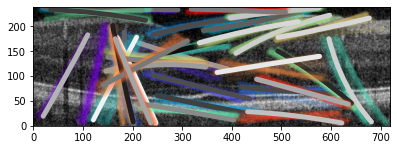


Iteration: 200
Time Remaining: 0 seconds
Fitness: [5.98, 4.46, 5.91, 5.97, 5.74, 5.24, 5.92, 5.98, 5.89, 5.96, 5.99, 5.96, 5.99, 5.98, 5.95, 6.0, -4.08, 4.68, 5.93, 5.96, 5.93, 5.97, 5.94, 5.41, 5.95, 5.93, 5.66, 5.97, 5.18, 5.95]
Mutation Rate: 0.00505
Tournament Size: 30

### PROFILING ###
Total program time: 133.34 sec
Function times:
- outside: 6.02 sec (4.52%), 252000 calls
- g_cross_factor: 95.75 sec (71.81%), 252000 calls
- width: 0.55 sec (0.41%), 252000 calls
- length: 0.30 sec (0.22%), 252000 calls
- get: 105.41 sec (79.06%), 252000 calls
- update: 111.91 sec (83.93%), 6000 calls
- avg_worm: 0.06 sec (0.05%), 270 calls



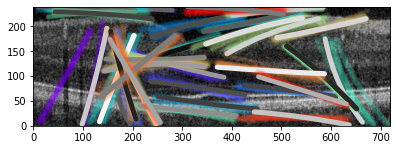

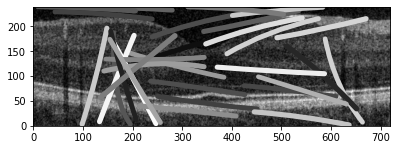

In [24]:
# for profiling
start_time = time.time()
function_times = {}
profiling = True # change to True to see function times
# constants
iterations = 200
swarm_size = 40
num_swarms = 30
swarms = [Swarm(image, initialise_clew(swarm_size, image.shape, (40, 30, 1))) for _ in range(num_swarms)]
fitness = Fitness(image, swarms)
for s in swarms:
    s.fitness = fitness
    #s.tnm_k = 4
    #s.m_rate = 0.02

for it in range(iterations):
    fitnesses = []
    for swarm in swarms:
        # start the mutation rate high for a short time then keep it low for a long time (exponential)
        # allows for fast exploration at the start with fine tuning of the final solution at the end
        swarm.m_rate = 0.1 * np.exp(-3 * (it / iterations)) # -3 growth rate so it quickly decreases
        # same principle with tournament size, except that it starts low and increases over time
        # if tournament size = population, all children will come from the best parent (no diversity)
        swarm.tnm_k = max(int(len(swarm.population) / (1+np.exp(-5 * (it/iterations-0.8)))+1), 2) 
        swarm.update()
    if (it+1) % (iterations//10) == 0:
        all_fitnesses = [sum(x) / len(x) for x in [[fitness.get(w) for w in p.population] for p in swarms]]
        print("Iteration:",it+1)
        print("Time Remaining:",int((time.time() - start_time) / (it+1) * (iterations - (it+1))),"seconds")
        print("Fitness:",[float(f"{x:.3}") for x in all_fitnesses])
        print(f"Mutation Rate: {swarms[0].m_rate:.3}")
        print(f"Tournament Size: {swarms[0].tnm_k}")
        if profiling:
            print_function_times()
        drawing = Drawing(image)
        for ix in range(len(swarms)):
            drawing.add_worms(swarms[ix].population, alpha=0.05, colour=(ix/len(swarms)))
            drawing.add_worms(swarms[ix].avg_worm())
        drawing.show()
        print()
drawing = Drawing(image)
for ix in range(len(swarms)):
    drawing.add_worms(swarms[ix].avg_worm())
drawing.show()
    